# This script compares the range of CDR pathways in the scenarios used in our study with all scenarios (that include CDR) from the IPCC Special Report on 1.5°C database

In [1]:
#!{sys.executable} -m pip install geopandas
#!conda install --yes --prefix {sys.prefix} geopandas
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from scipy import integrate
import seaborn as sns
import itertools
#from IAM_region_mapping import mappingDict
import json

In [2]:
# Paths
data_path = ""
plot_path = ""

SR15_data = pd.read_excel(data_path + 'SR15_data_afolu.xlsx')

main_remind=pd.read_excel(data_path+'REMIND_prepINPUT_use.xls')
main_image=pd.read_excel(data_path+'IMAGE_prepINPUT_use.xls')
main_message=pd.read_excel(data_path+'MESSAGE_prepINPUT_use.xls')

SR15_metadata = pd.read_excel(data_path + 'SR15_metadata_scens.xlsx')

In [3]:
SR15_metadata['mod_scen'] = SR15_metadata['model'] + '_' + SR15_metadata['scenario']


In [4]:
low15 = ['1.5C low overshoot', 'Below 1.5C']
high15 = ['1.5C high overshoot']
deg2 = ['Higher 2C', 'Lower 2C', 'Above 2C']

SR15_metadata_15lo = SR15_metadata.loc[SR15_metadata.category.isin(low15)]
SR15_metadata_15ho = SR15_metadata.loc[SR15_metadata.category.isin(high15)]
SR15_metadata_2 = SR15_metadata.loc[SR15_metadata.category.isin(deg2)]

SR15_metadata_15lo.category.unique()

array(['1.5C low overshoot', 'Below 1.5C'], dtype=object)

In [5]:
list_15lo = SR15_metadata_15lo['mod_scen'].tolist()

In [6]:
SR15_data.head()


#SR15_data = SR15_data[['Model', 'Scenario', 'Region', 'Unit', 'Variable', '2020', '2030', '2040', '2050', '2060', '2070', '2080', '2090', '2100']]

,Model,Scenario,Region,Variable,Unit,2020,2030,2040,2050,2060,2070,2080,2090,2100
0,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Carbon Sequestration|CCS|Biomass,Mt CO2/yr,0.0000,64.1828,2198.6567,6313.5634,10378.3914,12757.8251,13109.3657,12746.8163,14345.9453
1,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Carbon Sequestration|Land Use,Mt CO2/yr,-1677.9919,-2382.5692,-4236.5300,-2645.2710,-2496.0551,-2309.5851,-2231.1938,-3509.5708,-2036.5747
2,AIM/CGE 2.0,ADVANCE_2020_Med2C,World,Carbon Sequestration|CCS|Biomass,Mt CO2/yr,0.0000,28.9408,938.6529,2576.8608,4697.5802,6008.1751,6238.2805,6645.7250,7987.0365
3,AIM/CGE 2.0,ADVANCE_2020_Med2C,World,Carbon Sequestration|Land Use,Mt CO2/yr,-1677.1334,-2312.8502,-4137.8451,-5254.8083,-4883.2896,-4631.3802,-4342.4208,-3952.0203,-3614.4855
4,AIM/CGE 2.0,ADVANCE_2020_WB2C,World,Carbon Sequestration|CCS|Biomass,Mt CO2/yr,0.0000,29.1757,1383.7040,3658.6111,5755.7952,7008.7308,7479.3816,7981.9948,8418.9745


In [139]:


SR15_data_M = SR15_data.set_index(['Model', 'Scenario', 'Region', 'Unit', 'Variable']).stack().reset_index()

SR15_data_M = SR15_data_M.rename(columns={"level_5": "Year", 0: "Value"})
SR15_data_M = SR15_data_M[['Model', 'Scenario', 'Region', 'Unit', 'Year','Value','Variable']]

#SR15_data_M = SR15_data_M.iloc[:,6].transpose()
SR15_data_M = SR15_data_M.pivot_table(index =['Model', 'Scenario', 'Region', 'Unit', 'Year'],  columns = 'Variable', values = 'Value')

SR15_data_M = SR15_data_M.reset_index() 
SR15_data_M = SR15_data_M.fillna(0)
SR15_data_M['Emissions|CO2|AFOLU'].values[SR15_data_M['Emissions|CO2|AFOLU'] > 0] = 0
SR15_data_M['Emissions|CO2|AFOLU'] = SR15_data_M['Emissions|CO2|AFOLU']*(-1)
SR15_data_M['Carbon Sequestration|Land Use'] = SR15_data_M['Carbon Sequestration|Land Use'].abs()
SR15_data_M['Carbon Sequestration|Direct Air Capture'] = SR15_data_M['Carbon Sequestration|Direct Air Capture'].abs()


In [80]:
SR15_data_M.loc[SR15_data_M.Scenario == 'SFCM_SSP2_combined_2Degree']

Variable,Model,Scenario,Region,Unit,Year,Carbon Sequestration|CCS|Biomass,Carbon Sequestration|Direct Air Capture,Carbon Sequestration|Enhanced Weathering,Carbon Sequestration|Land Use,Emissions|CO2|AFOLU,Total_CDR
234,AIM/CGE 2.0,SFCM_SSP2_combined_2Degree,World,Mt CO2/yr,2020,0.0,0.0,0.0,0.0,-0.0000,0.000000
235,AIM/CGE 2.0,SFCM_SSP2_combined_2Degree,World,Mt CO2/yr,2030,0.0,0.0,0.0,0.0,-0.0000,0.000000
236,AIM/CGE 2.0,SFCM_SSP2_combined_2Degree,World,Mt CO2/yr,2040,0.0,0.0,0.0,0.0,-0.0000,0.000000
237,AIM/CGE 2.0,SFCM_SSP2_combined_2Degree,World,Mt CO2/yr,2050,0.0,0.0,0.0,0.0,-0.0000,0.000000
238,AIM/CGE 2.0,SFCM_SSP2_combined_2Degree,World,Mt CO2/yr,2060,0.0,0.0,0.0,0.0,-0.0000,0.000000
239,AIM/CGE 2.0,SFCM_SSP2_combined_2Degree,World,Mt CO2/yr,2070,0.0,0.0,0.0,0.0,787.9772,0.787977
240,AIM/CGE 2.0,SFCM_SSP2_combined_2Degree,World,Mt CO2/yr,2080,0.0,0.0,0.0,0.0,1012.4690,1.012469
241,AIM/CGE 2.0,SFCM_SSP2_combined_2Degree,World,Mt CO2/yr,2090,0.0,0.0,0.0,0.0,1395.7196,1.395720
242,AIM/CGE 2.0,SFCM_SSP2_combined_2Degree,World,Mt CO2/yr,2100,0.0,0.0,0.0,0.0,1308.0011,1.308001


In [140]:
SR15_data_M['Total_CDR'] = 0
SR15_data_M['Year'] = SR15_data_M['Year'].astype(int)
SR15_data_M['Total_CDR'] = SR15_data_M['Carbon Sequestration|CCS|Biomass'] + SR15_data_M['Carbon Sequestration|Direct Air Capture'] + SR15_data_M['Carbon Sequestration|Land Use']+ SR15_data_M['Carbon Sequestration|Enhanced Weathering'] + SR15_data_M['Emissions|CO2|AFOLU'] 


In [17]:
main_remind['TOTAL_CDR'] = main_remind['TOTAL_CDR']/1000
main_image['TOTAL_CDR'] = main_image['TOTAL_CDR']/1000
main_message['TOTAL_CDR'] = main_message['TOTAL_CDR']/1000

In [141]:
SR15_data_M['Total_CDR'] = SR15_data_M['Total_CDR']/1000

In [7]:

indexNames = main_image[main_image['Scenario'] == 'SSP2-Ref-SPA0-V17'].index  #'SSP2-Ref-SPA0-V17' #'SSP1-Ref-SPA0-V17'
main_image.drop(indexNames , inplace=True)
indexNames = main_image[main_image['Scenario'] == 'SSP1-Ref-SPA0-V17'].index  #'SSP2-Ref-SPA0-V17' #'SSP1-Ref-SPA0-V17'
main_image.drop(indexNames , inplace=True)


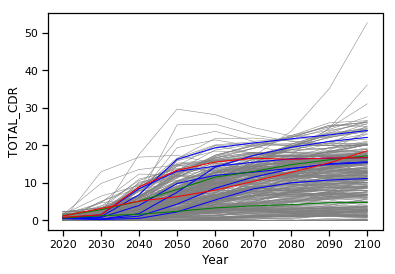

In [81]:


for mod in SR15_data_M.Model.unique():
    SR15_F = SR15_data_M.loc[SR15_data_M.Model == mod]
    for scen in SR15_F.Scenario.unique():
        SR15_F_S = SR15_F.loc[SR15_F.Scenario == scen]
        sns.lineplot(x='Year',y='Total_CDR',data=SR15_F_S, linewidth = 0.5, color = 'gray')
        
for scen in main_remind.Scenario.unique():
    remind_S = main_remind.loc[(main_remind.Scenario == scen)& (main_remind.Region == 'World')]
    sns.lineplot(x='Year',y='TOTAL_CDR',data=remind_S, linewidth = 1, color = 'blue')
    
for scen in main_message.Scenario.unique():
    message_S = main_message.loc[(main_message.Scenario == scen) & (main_message.Region == 'World')]
    sns.lineplot(x='Year',y='TOTAL_CDR',data=message_S, linewidth = 1, color = 'green')
    
for scen in main_image.Scenario.unique():
    image_S = main_image.loc[(main_image.Scenario == scen) & (main_image.Region == 'World')]
    sns.lineplot(x='Year',y='TOTAL_CDR',data=image_S, linewidth = 1, color = 'red')
    


#plt.savefig(plot_path + 'Total_CDR_15.png')






In [8]:
SR15_box = pd.melt(SR15_data, id_vars =['Model', 'Scenario', 'Region', 'Variable', 'Unit'], value_vars =['2020', '2030', '2040', '2050', '2060', '2070', '2080', '2090', '2100'])

SR15_box = SR15_box.rename(columns={"variable": "Year"})

SR15_box['model_scena'] = SR15_box['Model'] + '_' + SR15_box['Scenario']
SR15_box

,Model,Scenario,Region,Variable,Unit,Year,value,model_scena
0,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Carbon Sequestration|CCS|Biomass,Mt CO2/yr,2020,0.000000,AIM/CGE 2.0_ADVANCE_2020_1.5C-2100
1,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Carbon Sequestration|Land Use,Mt CO2/yr,2020,-1677.991900,AIM/CGE 2.0_ADVANCE_2020_1.5C-2100
2,AIM/CGE 2.0,ADVANCE_2020_Med2C,World,Carbon Sequestration|CCS|Biomass,Mt CO2/yr,2020,0.000000,AIM/CGE 2.0_ADVANCE_2020_Med2C
3,AIM/CGE 2.0,ADVANCE_2020_Med2C,World,Carbon Sequestration|Land Use,Mt CO2/yr,2020,-1677.133400,AIM/CGE 2.0_ADVANCE_2020_Med2C
4,AIM/CGE 2.0,ADVANCE_2020_WB2C,World,Carbon Sequestration|CCS|Biomass,Mt CO2/yr,2020,0.000000,AIM/CGE 2.0_ADVANCE_2020_WB2C
5,AIM/CGE 2.0,ADVANCE_2020_WB2C,World,Carbon Sequestration|Land Use,Mt CO2/yr,2020,-1677.133400,AIM/CGE 2.0_ADVANCE_2020_WB2C
6,AIM/CGE 2.0,ADVANCE_2030_Med2C,World,Carbon Sequestration|CCS|Biomass,Mt CO2/yr,2020,0.000000,AIM/CGE 2.0_ADVANCE_2030_Med2C
7,AIM/CGE 2.0,ADVANCE_2030_Med2C,World,Carbon Sequestration|Land Use,Mt CO2/yr,2020,-1677.445500,AIM/CGE 2.0_ADVANCE_2030_Med2C
8,AIM/CGE 2.0,ADVANCE_2030_Price1.5C,World,Carbon Sequestration|CCS|Biomass,Mt CO2/yr,2020,0.000000,AIM/CGE 2.0_ADVANCE_2030_Price1.5C
9,AIM/CGE 2.0,ADVANCE_2030_Price1.5C,World,Carbon Sequestration|Land Use,Mt CO2/yr,2020,-1677.377200,AIM/CGE 2.0_ADVANCE_2030_Price1.5C


In [9]:
#for scen in SR15_box.model_scena.unique():
#    if scen.isin(list_15lo):
#       SR15_box['scen_cat'] = '15lo'

SR15_box = SR15_box.merge(SR15_metadata, left_on='model_scena', right_on='mod_scen', how='inner')
SR15_box = SR15_box.drop(columns = ['model', 'scenario', 'mod_scen'])
SR15_box['Total_CDR'] = 0
afolu_mask = (SR15_box.Variable == 'Emissions|CO2|AFOLU') & (SR15_box.value > 0)

SR15_box['value'][afolu_mask] = 0

SR15_box['value'] = SR15_box['value'].abs()
SR15_box.loc[SR15_box.Scenario == 'SSP5-19']

/Users/susannebaur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


,Model,Scenario,Region,Variable,Unit,Year,value,model_scena,category,Total_CDR
1188,GCAM 4.2,SSP5-19,World,Carbon Sequestration|CCS|Biomass,Mt CO2/yr,2020,59.868715,GCAM 4.2_SSP5-19,1.5C high overshoot,0
1189,GCAM 4.2,SSP5-19,World,Emissions|CO2|AFOLU,Mt CO2/yr,2020,0.000000,GCAM 4.2_SSP5-19,1.5C high overshoot,0
1190,GCAM 4.2,SSP5-19,World,Carbon Sequestration|CCS|Biomass,Mt CO2/yr,2030,1774.181509,GCAM 4.2_SSP5-19,1.5C high overshoot,0
1191,GCAM 4.2,SSP5-19,World,Emissions|CO2|AFOLU,Mt CO2/yr,2030,0.000000,GCAM 4.2_SSP5-19,1.5C high overshoot,0
1192,GCAM 4.2,SSP5-19,World,Carbon Sequestration|CCS|Biomass,Mt CO2/yr,2040,8052.133733,GCAM 4.2_SSP5-19,1.5C high overshoot,0
1193,GCAM 4.2,SSP5-19,World,Emissions|CO2|AFOLU,Mt CO2/yr,2040,9485.875187,GCAM 4.2_SSP5-19,1.5C high overshoot,0
1194,GCAM 4.2,SSP5-19,World,Carbon Sequestration|CCS|Biomass,Mt CO2/yr,2050,10281.303630,GCAM 4.2_SSP5-19,1.5C high overshoot,0
1195,GCAM 4.2,SSP5-19,World,Emissions|CO2|AFOLU,Mt CO2/yr,2050,19376.047190,GCAM 4.2_SSP5-19,1.5C high overshoot,0
1196,GCAM 4.2,SSP5-19,World,Carbon Sequestration|CCS|Biomass,Mt CO2/yr,2060,11069.746880,GCAM 4.2_SSP5-19,1.5C high overshoot,0
1197,GCAM 4.2,SSP5-19,World,Emissions|CO2|AFOLU,Mt CO2/yr,2060,17111.254530,GCAM 4.2_SSP5-19,1.5C high overshoot,0


In [10]:
SR15_box_2050 = SR15_box.loc[SR15_box.Year == '2050', :]
SR15_box_2100 = SR15_box.loc[SR15_box.Year == '2100', :]

for mod in SR15_box_2050.model_scena.unique():
    SR15_box_2050.loc[SR15_box_2050.model_scena == mod, 'Total_CDR'] = SR15_box_2050.loc[SR15_box_2050.model_scena == mod, 'value'].sum()

for mod in SR15_box_2100.model_scena.unique():
    SR15_box_2100.loc[SR15_box_2100.model_scena == mod, 'Total_CDR'] = SR15_box_2100.loc[SR15_box_2100.model_scena == mod, 'value'].sum()

/Users/susannebaur/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [99]:
SR15_box_2050.loc[SR15_box_2050.Scenario == 'SSP5-19']

,Model,Scenario,Region,Variable,Unit,Year,value,model_scena,category,Total_CDR
1194,GCAM 4.2,SSP5-19,World,Carbon Sequestration|CCS|Biomass,Mt CO2/yr,2050,10281.30363,GCAM 4.2_SSP5-19,1.5C high overshoot,29657.35082
1195,GCAM 4.2,SSP5-19,World,Emissions|CO2|AFOLU,Mt CO2/yr,2050,19376.04719,GCAM 4.2_SSP5-19,1.5C high overshoot,29657.35082
3939,REMIND-MAgPIE 1.5,SSP5-19,World,Carbon Sequestration|CCS|Biomass,Mt CO2/yr,2050,16100.00000,REMIND-MAgPIE 1.5_SSP5-19,1.5C high overshoot,16100.00000
3940,REMIND-MAgPIE 1.5,SSP5-19,World,Emissions|CO2|AFOLU,Mt CO2/yr,2050,0.00000,REMIND-MAgPIE 1.5_SSP5-19,1.5C high overshoot,16100.00000


In [11]:
SR15_box_2050['category'] = SR15_box_2050['category'].map({'1.5C low overshoot': '15lo', 'Higher 2C': 'deg2',
                                                          'Lower 2C': 'deg2', 'Above 2C': 'deg2', '1.5C high overshoot': '15ho',
                                                          'Below 1.5C': '15lo'})

SR15_box_2100['category'] = SR15_box_2100['category'].map({'1.5C low overshoot': '15lo', 'Higher 2C': 'deg2',
                                                          'Lower 2C': 'deg2', 'Above 2C': 'deg2', '1.5C high overshoot': '15ho',
                                                          'Below 1.5C': '15lo'})
SR15_box_2100.category.unique()

/Users/susannebaur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/susannebaur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


array(['15lo', 'deg2', '15ho'], dtype=object)

In [16]:
SR15_boxplot = SR15_box_2050.append(SR15_box_2100)

SR15_boxplot['Total_CDR'] = SR15_boxplot['Total_CDR']/1000

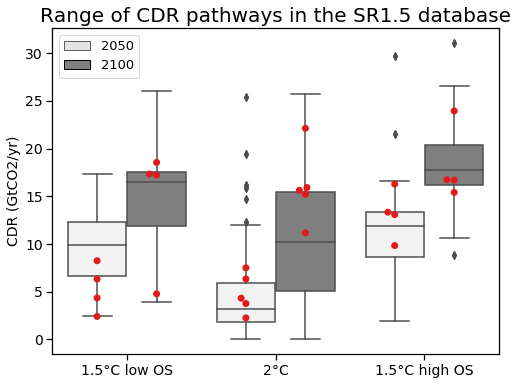

In [22]:


from matplotlib.patches import Patch


sns.set_context("notebook", font_scale=1, rc={"axes.labelsize":12})

f, axes = plt.subplots(1, 1, figsize=(8,6))


colours = sns.color_palette("Paired",12)
colour_palette = [colours[5], colours[5]]


box1 = sns.boxplot(x="category", y="Total_CDR", data=SR15_boxplot, order = ['15lo', 'deg2', '15ho'], hue = 'Year', hue_order = ['2050', '2100'], color = 'gray')
box1 = sns.swarmplot(x="category", y="TOTAL_CDR", data=boxplot_ourmodels, order = ['15lo', 'deg2', '15ho'], palette = colour_palette, hue = 'Year', marker = 'o',facecolors='none', s = 7, dodge = True)


l = plt.legend(handles =  [Patch(facecolor='lightgray', alpha = 0.6, edgecolor='k',label='2050'), 
                           Patch(facecolor='grey', edgecolor='k',label='2100')], fontsize = 13)


box1.set_ylabel("CDR (GtCO2/yr)", fontsize = 14)
box1.set_xlabel('')
#box1.set(ylim =(-25,450))
box1.set_xticklabels(['1.5°C low OS', '2°C', '1.5°C high OS'])
box1.set_title("Range of CDR pathways in the SR1.5 database", fontsize=20)  #Cumulative CDR obligations in 2100 | equity: 
box1.tick_params(labelsize=14)

plt.savefig(plot_path + 'Final_Final_Plots/Plots_Colourblind/Boxplot_Total_CDR.png')

In [18]:
box_ourmodels = main_remind.append([main_image, main_message])
box_ourmodels['category'] = box_ourmodels['Scenario'].map({'SSP1-19-SPA0-V17': '15lo', 'LowEnergyDemand': '15lo', 'SSP1-19': '15lo', 'SSP2-26-SPA2-V17': 'deg2','SSP1-26-SPA1-V17': 'deg2', 'SSP5-26-SPA5-V17': 'deg2',
                                                           'SSP2-LF-SPA2-V17': '15ho', 'SSP1-19-SPA1-V17': '15ho', 'SSP2-19-SPA2-V17': '15ho', 'SSP5-19-SPA5-V17': '15ho', 'SSP1-26': 'deg2', 'SSP2-19': '15lo', 'SSP2-26': 'deg2'})
box_ourmodels_2050 = box_ourmodels.loc[(box_ourmodels.Year == 2050) & (box_ourmodels.Region == 'World'), :]
box_ourmodels_2100 = box_ourmodels.loc[(box_ourmodels.Year == 2100) & (box_ourmodels.Region == 'World'), :]

boxplot_ourmodels = box_ourmodels_2050.append(box_ourmodels_2100)

In [19]:
box_ourmodels_2050

,Unnamed: 0,MODEL,Region,Scenario,Year,Total_CO2,Total_GHG,BECCS,LANDCDR,TOTAL_CDR,...,CUM_CO2,CUM_CDR,Unit_CO2,Population,GDP,Unit_Population,cumPopulation,2016_emissions,em_change,category
102,102,REMIND,World,SSP1-19-SPA1-V17,2050,3760.554100,11810.000000,9330.000000,508.009300,9.838009,...,2.379040e+06,100725.793900,Mt/yr,8481.000000,282400.000000,Mio,442162.005500,50164.4966,0.431540,15ho
210,210,REMIND,World,SSP2-19-SPA2-V17,2050,-7249.559700,1511.000000,12760.000000,327.050300,13.087050,...,2.421690e+06,168939.787500,Mt/yr,9187.000000,215700.000000,Mio,453694.505500,50164.4966,0.291004,15ho
318,318,REMIND,World,SSP1-26-SPA1-V17,2050,21375.415500,30500.000000,2145.000000,119.527300,2.264527,...,2.600235e+06,22447.283500,Mt/yr,8481.000000,287300.000000,Mio,442162.005500,50164.4966,0.653142,deg2
426,426,REMIND,World,SSP2-26-SPA2-V17,2050,19351.507600,28390.000000,4239.000000,87.765400,4.326765,...,2.687065e+06,39385.764600,Mt/yr,9187.000000,227600.000000,Mio,453694.505500,50164.4966,0.652190,deg2
534,534,REMIND,World,SSP5-19-SPA5-V17,2050,1254.270600,10760.000000,16070.000000,215.728600,16.285729,...,2.660232e+06,163182.390400,Mt/yr,8579.000000,338400.000000,Mio,443599.505500,50164.4966,0.539141,15ho
642,642,REMIND,World,SSP5-26-SPA5-V17,2050,24985.273800,35120.000000,7425.000000,83.136800,7.508137,...,2.918177e+06,63397.259600,Mt/yr,8579.000000,351600.000000,Mio,443599.505500,50164.4966,0.849767,deg2
237,237,IMAGE,World,SSP1-19-SPA0-V17,2050,1611.345581,7926.809082,3924.803613,2403.422396,6.328226,...,1.987297e+06,121925.857161,Mt/yr,8530.500000,291301.406250,Mio,446527.609262,47200.0000,0.302013,15lo
480,480,IMAGE,World,SSP2-LF-SPA2-V17,2050,-256.401301,8000.666992,11897.060351,1444.026182,13.341087,...,2.266763e+06,176213.977457,Mt/yr,9242.542969,234213.406250,Mio,458144.878549,47200.0000,0.452156,15ho
93,93,MESSAGE,World,SSP1-19,2050,3629.964971,10845.168829,4449.544000,3804.514994,8.254059,...,2.226624e+06,128697.007916,Mt/yr,8461.400000,310327.930000,Mio,444422.915073,47200.0000,0.404645,15lo
192,192,MESSAGE,World,SSP1-26,2050,19794.238344,28364.714888,2700.195667,3645.704889,6.345901,...,2.549004e+06,103103.018425,Mt/yr,8461.400000,313023.040000,Mio,444422.915073,47200.0000,0.735394,deg2


In [53]:
box_ourmodels_2050.to_excel(data_path + 'box_ourmodels_2050.xls')
SR15_boxplot.to_excel(data_path + 'SR15_boxplot_afolu.xls')
SR15_box_2100.to_excel(data_path + 'SR15_box_2100.xls')